In [1]:
from nltk import pos_tag
import pandas as pd
import numpy as np 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import nltk 
from itertools import chain
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
import pyLDAvis
import pyLDAvis.gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import LsiModel
import spacy
from pprint import pprint
nltk.download('punkt')
nltk.download('stopwords')
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

C:\Users\giorg\anaconda3\lib\site-packages\sklearn\decomposition\_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps
C:\Users\giorg\anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
C:\Users\giorg\anaconda3\lib\site-packages\tensorflow\core\framework\tensor_shape_pb2.py:18: DeprecationWarning: Call to deprecated create function FileDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or qu

C:\Users\giorg\anaconda3\lib\site-packages\tensorflow\python\ops\numpy_ops\np_random.py:95: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def randint(low, high=None, size=None, dtype=onp.int):  # pylint: disable=missing-function-docstring
C:\Users\giorg\anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:572: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more de

In [2]:
pd.set_option('display.max_colwidth', None)
df = pd.read_csv(r'C:\Users\giorg\clean_text.csv', encoding = 'utf-8-sig')

# Pre-Processing

In [3]:
text = df['text']
text = list(text)


In [4]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

text_words = list(sent_to_words(text))

print(text_words[:1])

[['folks', 'paste', 'cytokine', 'storm', 'pfizerbiontech']]


In [5]:
bigram = gensim.models.Phrases(text_words, min_count=1, threshold=10) 
trigram = gensim.models.Phrases(bigram[text_words], threshold=10)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

print(trigram_mod[bigram_mod[text_words[0]]])

['folks', 'paste', 'cytokine', 'storm', 'pfizerbiontech']


In [6]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [7]:
# Form Bigrams
text_words_bigrams = make_bigrams(text_words)

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
text_lemmatized = lemmatization(text_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(text_lemmatized[:1])

[['folk', 'paste', 'cytokine', 'storm', 'pfizerbiontech']]


In [8]:
id2word = corpora.Dictionary(text_lemmatized)

# Create Corpus
texts = text_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]]


In [9]:
id2word[0]

'cytokine'

In [10]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('cytokine', 1),
  ('folk', 1),
  ('paste', 1),
  ('pfizerbiontech', 1),
  ('storm', 1)]]

# Basic LSA model

In [11]:
lsa_model = LsiModel(corpus, id2word=id2word, num_topics=12)

In [12]:
pprint(lsa_model.print_topics())
doc_lda = lsa_model[corpus]

[(0,
  '0.839*"vaccine" + 0.416*"covid" + 0.256*"moderna" + 0.109*"dose" + '
  '0.078*"sputnikv" + 0.075*"pfizer" + 0.074*"covaxin" + '
  '0.071*"pfizerbiontech" + 0.051*"covidvaccine" + 0.037*"india"'),
 (1,
  '-0.909*"moderna" + 0.312*"vaccine" + -0.098*"dose" + -0.095*"covidvaccine" '
  '+ -0.094*"pfizer" + -0.092*"shoot" + 0.085*"sputnikv" + -0.077*"second" + '
  '0.073*"covaxin" + -0.070*"shot"'),
 (2,
  '0.886*"covid" + -0.403*"vaccine" + -0.161*"moderna" + 0.112*"covaxin" + '
  '0.072*"vaccination" + 0.050*"covidvaccine" + -0.039*"sputnikv" + 0.038*"_" '
  '+ 0.021*"pfizerbiontech" + 0.021*"jab"'),
 (3,
  '-0.938*"covaxin" + -0.210*"dose" + 0.152*"covid" + -0.116*"india" + '
  '-0.092*"covishield" + -0.084*"covidvaccine" + 0.058*"vaccine" + '
  '-0.048*"amp" + -0.036*"ocgn" + -0.033*"shoot"'),
 (4,
  '0.930*"dose" + -0.219*"covaxin" + 0.152*"pfizerbiontech" + '
  '0.142*"covidvaccine" + -0.140*"moderna" + -0.061*"vaccine" + -0.052*"shoot" '
  '+ 0.046*"sinopharm" + -0.043*"covid

# Model Evaluation

In [13]:
# Compute Coherence Score
coherence_model_lsa = CoherenceModel(model=lsa_model, texts=text_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lsa = coherence_model_lsa.get_coherence()
print('\nCoherence Score: ', coherence_lsa)


Coherence Score:  0.29545376001834134


# Finding ideal number of topics

In [16]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=2):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ---------- 
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model= LsiModel(corpus, id2word=id2word, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=text_lemmatized, dictionary=id2word, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

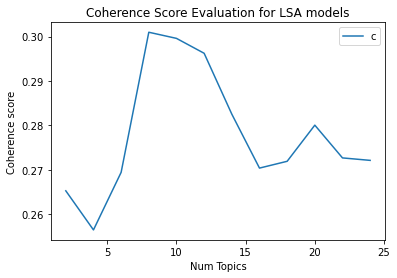

In [17]:
start=2; limit=25; step=2;

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=text_lemmatized, start=start, limit=limit, step=step)

# Show graph

x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.title('Coherence Score Evaluation for LSA models')
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()